In [321]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

In [322]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For full reproducibility (slightly slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


In [323]:
import numpy as np
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
#show the keys in the file
print(data.files)
embeddings = data['test_embeddings']
print("shape of embeddings:" , embeddings.shape)
probs= data['probs']
print("shape of probs:", probs.shape)
y_labels = data['y_labels']
print("Shape of labels:", y_labels.shape)
y_true = data['y_train']
print("Shape of y_true:", y_true.shape)



['test_embeddings', 'y_train', 'y_labels', 'audio_num', 'probs', 'audio_names']
shape of embeddings: (5702, 64)
shape of probs: (5702, 12)
Shape of labels: (5702,)
Shape of y_true: (5702, 12)


In [324]:
#Predicted class
y_hat = np.argmax(probs, axis=1)
print("predicted class :", y_hat)
#Prob of predicted class
p_y_hat = np.max(probs, axis=1)
print("predicted probabilities :", p_y_hat)

#True class one hot matrix
y_star= y_true
print("true class :", y_star)
#Prob of true class
p_y_star = np.sum(probs * y_star, axis=1)
print("true class probabilities :", p_y_star)

#True class labels
y_true_class = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true
print("true class labels :", y_true_class)


predicted class : [ 1 11  9 ... 11  9  1]
predicted probabilities : [0.544058   0.97347754 0.7518662  ... 0.96628433 0.9899086  0.9475812 ]
true class : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]
true class probabilities : [0.4308202  0.97347754 0.23816009 ... 0.96628433 0.98990858 0.94758117]
true class labels : [ 8 11 11 ... 11  9  1]


In [325]:
#Computing ECE
def compute_ECE(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.sum(in_bin) / total_samples

        if np.sum(in_bin) > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += (prop_in_bin )* np.abs(avg_confidence_in_bin - accuracy_in_bin)

    return ece


In [326]:
def compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha):
    indicator = (y_true_class != y_hat).astype(float)
    numerator = p_y_star
    denominator = p_y_hat + (indicator * (p_y_star + alpha))
    tcp_star_targets = numerator / denominator
    return tcp_star_targets

tcp_star_targets = compute_tcp_star_targets(y_true_class, y_hat, p_y_star, p_y_hat, alpha=0.3)
print("tcp_star_targets shape:", tcp_star_targets)

tcp_star_targets shape: [0.33793047 1.         0.18461646 ... 1.         1.         1.        ]


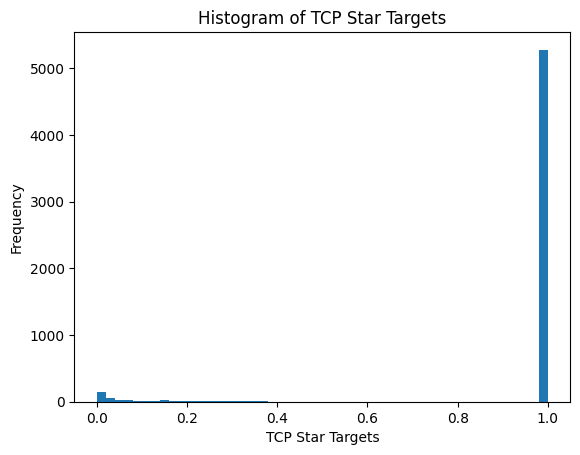

In [327]:
#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(tcp_star_targets, bins=50)
plt.xlabel('TCP Star Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Star Targets')
plt.show()

In [328]:
# Upsampling the errors to create a balanced batch 

# Select indices
correct_idx = np.where(y_hat == y_true_class)[0]
error_idx = np.where(y_hat != y_true_class)[0]

# You can duplicate errors to balance them
n_errors = len(error_idx)
n_correct = len(correct_idx)
upsample_errors = np.random.choice(error_idx, size=n_correct, replace=True)

balanced_idx = np.concatenate([correct_idx, upsample_errors])
np.random.shuffle(balanced_idx)

X_balanced = embeddings[balanced_idx]
y_balanced = tcp_star_targets[balanced_idx]
print("Balanced embeddings shape:", X_balanced.shape)
print("Balanced TCP Star Targets shape:", y_balanced.shape)

Balanced embeddings shape: (10552, 64)
Balanced TCP Star Targets shape: (10552,)


In [ ]:
from sklearn.model_selection import train_test_split
X= X_balanced
y= y_balanced
# 80% for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [330]:
import numpy as np
from scipy.stats import norm

def create_gaussian_target(y_vals, num_bins=20, sigma=0.1):
    bin_edges = np.linspace(0, 1, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    target_distributions = []
    for y in y_vals:
        # Gaussian centered at y
        p = norm.pdf(bin_centers, loc=y, scale=sigma)
        p /= p.sum()  # Normalize to sum to 1
        target_distributions.append(p)

    return np.array(target_distributions), bin_centers

In [331]:
def create_gaussian_target_dynamic_sigma(y_vals, num_bins=20, alpha=0.1, clip_sigma=(0.02, 0.2)):
    bin_edges = np.linspace(0, 1, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    target_distributions = []

    for y in y_vals:
        sigma = alpha * (1 - y)  # dynamic σ based on confidence
        sigma = np.clip(sigma, *clip_sigma)

        p = norm.pdf(bin_centers, loc=y, scale=sigma)
        p /= p.sum()
        target_distributions.append(p)

    return np.array(target_distributions), bin_centers

In [332]:
target_hists, bin_centers = create_gaussian_target_dynamic_sigma(
    y_train, num_bins=20, alpha=0.2
)

In [333]:
# Apply it
# num_bins = 20
# target_hists, bin_centers = create_gaussian_target(y_train, num_bins=num_bins)

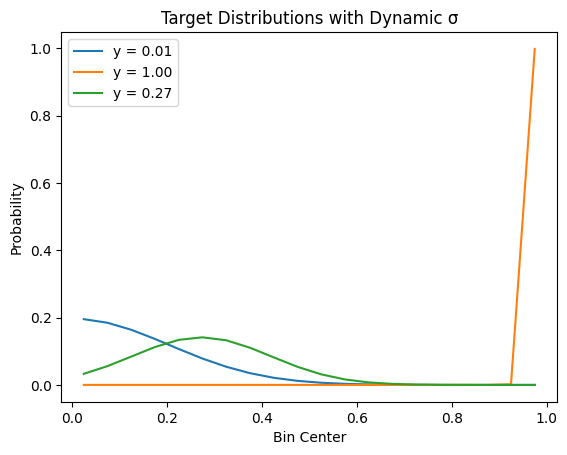

In [334]:
import matplotlib.pyplot as plt

for i in [0, 100, 500]:  
    plt.plot(bin_centers, target_hists[i], label=f'y = {y_train[i]:.2f}')
plt.legend()
plt.title("Target Distributions with Dynamic σ")
plt.xlabel("Bin Center")
plt.ylabel("Probability")
plt.show()

In [335]:
import torch.nn as nn

class ConfidenceNetHist(nn.Module):
    def __init__(self, input_dim):
        super(ConfidenceNetHist, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 20), 
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)


In [336]:
import torch
import torch.nn.functional as F

def histogram_loss(pred_q, target_p):
    # pred_q: (B, K), predicted softmax
    # target_p: (B, K), ground truth distributions
    return torch.mean(torch.sum(-target_p * torch.log(pred_q + 1e-8), dim=1))

In [337]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim import AdamW

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
p_train_tensor = torch.tensor(target_hists, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, p_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

input_dim = X_train.shape[1]
model = ConfidenceNetHist(input_dim)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
lambda_entropy = 0.3 # Weight for the entropy term
for epoch in range(100):
    model.train()
    train_losses = []
    for xb, pb in train_loader:
        pred_q = model(xb)
        histogram= histogram_loss(pred_q, pb)

        entropy = -torch.sum(pred_q * torch.log(pred_q + 1e-8), dim=1).mean()
        total_loss = histogram + lambda_entropy * entropy

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        train_losses.append(total_loss.item())

    print(f"Epoch {epoch+1:02d} | Train Loss: {np.mean(train_losses):.6f}")

Epoch 01 | Train Loss: 2.277659
Epoch 02 | Train Loss: 2.006320
Epoch 03 | Train Loss: 1.949371
Epoch 04 | Train Loss: 1.921348
Epoch 05 | Train Loss: 1.877370
Epoch 06 | Train Loss: 1.848939
Epoch 07 | Train Loss: 1.821475
Epoch 08 | Train Loss: 1.809252
Epoch 09 | Train Loss: 1.781836
Epoch 10 | Train Loss: 1.757244
Epoch 11 | Train Loss: 1.743402
Epoch 12 | Train Loss: 1.728813
Epoch 13 | Train Loss: 1.718389
Epoch 14 | Train Loss: 1.698370
Epoch 15 | Train Loss: 1.692571
Epoch 16 | Train Loss: 1.674365
Epoch 17 | Train Loss: 1.666801
Epoch 18 | Train Loss: 1.661138
Epoch 19 | Train Loss: 1.635757
Epoch 20 | Train Loss: 1.638864
Epoch 21 | Train Loss: 1.626648
Epoch 22 | Train Loss: 1.600764
Epoch 23 | Train Loss: 1.627970
Epoch 24 | Train Loss: 1.608510
Epoch 25 | Train Loss: 1.598591
Epoch 26 | Train Loss: 1.605844
Epoch 27 | Train Loss: 1.600000
Epoch 28 | Train Loss: 1.584624
Epoch 29 | Train Loss: 1.576552
Epoch 30 | Train Loss: 1.583296
Epoch 31 | Train Loss: 1.566367
Epoch 32

In [338]:
def extract_mean_std(pred_q, bin_centers):
    bin_centers = torch.tensor(bin_centers, dtype=pred_q.dtype, device=pred_q.device)
    mean = (pred_q * bin_centers).sum(dim=1)
    var = (pred_q * (bin_centers - mean[:, None])**2).sum(dim=1)
    return mean, torch.sqrt(var)

In [339]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(embeddings, dtype=torch.float32)
    pred_q = model(X_test_tensor)  # shape: (N, K), softmax histogram

    # Extract predicted confidence scores as expected value of distribution
    bin_centers_tensor = torch.tensor(bin_centers, dtype=torch.float32, device=pred_q.device)
    confidence_scores_tcpr, uncertainty_scores = extract_mean_std(pred_q, bin_centers)
    confidence_scores_tcpr = confidence_scores_tcpr.cpu().numpy()
    uncertainty_scores = uncertainty_scores.cpu().numpy()
print("Confidence scores shape:", confidence_scores_tcpr.shape)  # should be (5702,)
print("Uncertainty scores shape:", uncertainty_scores.shape)  # should be (5702,)


Confidence scores shape: (5702,)
Uncertainty scores shape: (5702,)


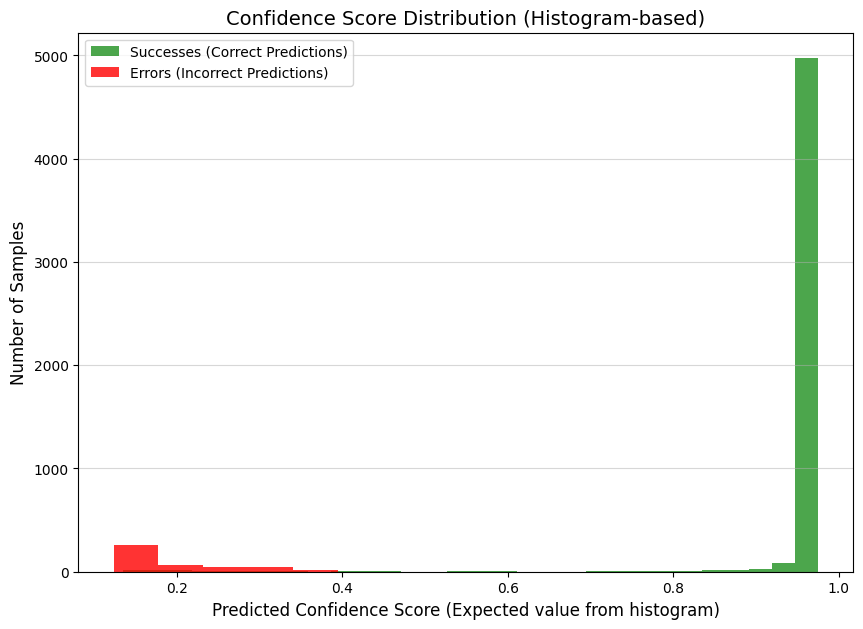

In [340]:

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_labels_int = label_encoder.fit_transform(y_labels)  # Optional if needed
is_correct = (y_hat == y_true_class)  # Make sure y_hat and y_true_class are defined

success_confidences = confidence_scores_tcpr[is_correct]
error_confidences = confidence_scores_tcpr[~is_correct]

# ----- Step 3: Plot confidence distribution
plt.figure(figsize=(10, 7))

plt.hist(success_confidences, bins=30, alpha=0.7, label='Successes (Correct Predictions)', color='green')
plt.hist(error_confidences, bins=15, alpha=0.8, label='Errors (Incorrect Predictions)', color='red')

plt.xlabel('Predicted Confidence Score (Expected value from histogram)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Confidence Score Distribution (Histogram-based)', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

In [341]:
ece_confidnet= compute_ECE(confidence_scores_tcpr, y_hat, y_labels_int)
print(f"ECE for Your Learned Confidence Model (TCP*): {ece_confidnet:.4f}")

ECE for Your Learned Confidence Model (TCP*): 0.0319


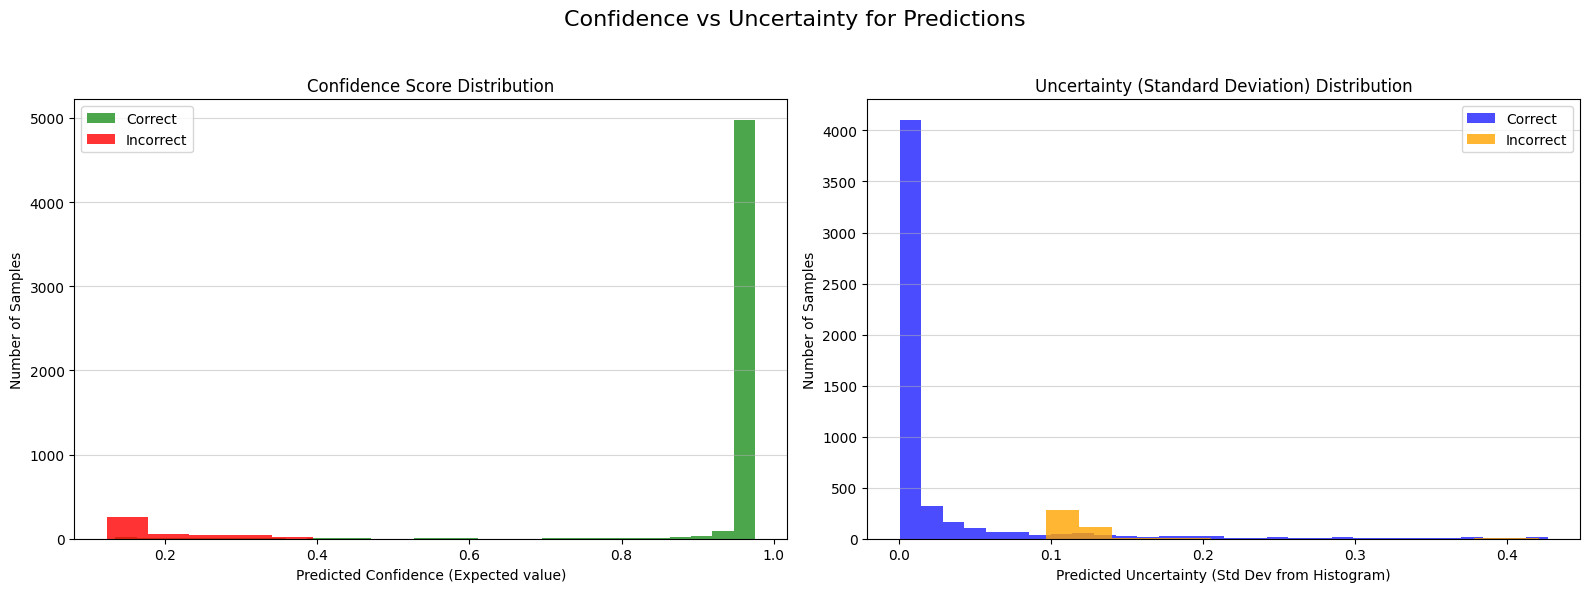

In [342]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Assuming: y_hat, y_true_class are defined
label_encoder = LabelEncoder()
y_labels_int = label_encoder.fit_transform(y_labels)

# Determine which predictions are correct
is_correct = (y_hat == y_true_class)

# Split confidence and uncertainty by correctness
success_confidences = confidence_scores_tcpr[is_correct]
error_confidences = confidence_scores_tcpr[~is_correct]

success_uncertainty = uncertainty_scores[is_correct]
error_uncertainty = uncertainty_scores[~is_correct]

# ----- Plot both confidence and uncertainty
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot confidence distribution
axs[0].hist(success_confidences, bins=30, alpha=0.7, label='Correct', color='green')
axs[0].hist(error_confidences, bins=15, alpha=0.8, label='Incorrect', color='red')
axs[0].set_title('Confidence Score Distribution')
axs[0].set_xlabel('Predicted Confidence (Expected value)')
axs[0].set_ylabel('Number of Samples')
axs[0].legend()
axs[0].grid(axis='y', alpha=0.5)

# Plot uncertainty distribution
axs[1].hist(success_uncertainty, bins=30, alpha=0.7, label='Correct', color='blue')
axs[1].hist(error_uncertainty, bins=15, alpha=0.8, label='Incorrect', color='orange')
axs[1].set_title('Uncertainty (Standard Deviation) Distribution')
axs[1].set_xlabel('Predicted Uncertainty (Std Dev from Histogram)')
axs[1].set_ylabel('Number of Samples')
axs[1].legend()
axs[1].grid(axis='y', alpha=0.5)

plt.suptitle('Confidence vs Uncertainty for Predictions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [343]:
def plot_reliability_diagram(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)
    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_accs, bin_confs = [], []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        if np.sum(in_bin) > 0:
            bin_accs.append(np.mean(accuracies[in_bin]))
            bin_confs.append(np.mean(confidences[in_bin]))

    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.plot(bin_confs, bin_accs, marker='o', label='Model')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_reliability_diagram(confidence_scores_tcpr, y_hat, y_true_class, n_bins=15)